# Projet ADEME : Recherche opérationnelle

### Importation des librairies

In [16]:
# Importer les bibliothèques nécessaires
import pulp
import time
import random
import itertools
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

### Fonctions générales

In [17]:
def generate_graph(N, restriction_probability=0.1, distance_range=(1, 100), time_range=(1, 60)):
    # Crée un graphe complet avec n sommets
    G = nx.complete_graph(N)

    # Parcourt toutes les arêtes du graphe
    for u, v in G.edges():
        # Pour chaque arête, on attribue une distance et un temps
        # Avec une probabilité 'restriction_probability', on met une valeur élevée (999) pour simuler une contrainte
        G[u][v]['distance'] = 999 if random.random() < restriction_probability else random.randint(*distance_range)
        G[u][v]['time'] = 999 if random.random() < restriction_probability else random.randint(*time_range)

    return G

def draw_graph(G, routes=None, depots=[0], title="Graphe complet généré aléatoirement"):
    # Calcule les positions des nœuds pour affichage (mise en page stable grâce à seed=42)
    pos = nx.spring_layout(G, seed=42)

    # Prépare les étiquettes des arêtes avec distance et temps
    edge_labels = {(u, v): f"D:{G.edges[u, v]['distance']}, T:{G.edges[u, v]['time']}" for u, v in G.edges}

    plt.figure(figsize=(8, 5))
    plt.title(title)

    # Affiche les nœuds : verts pour les dépôts, bleus sinon
    nx.draw_networkx_nodes(G, pos, node_color=['lightgreen' if n in depots else 'lightblue' for n in G.nodes], node_size=250)
    # Affiche les étiquettes des nœuds (identifiants)
    nx.draw_networkx_labels(G, pos, font_size=7)
    # Affiche les arêtes en gris clair par défaut
    nx.draw_networkx_edges(G, pos, alpha=0.2)

    # Si des routes sont fournies, on les dessine en couleurs plus visibles
    if routes:
        line_color = ["red", "blue", "green", "orange", "purple"]
        for k, edges in enumerate(routes):
            nx.draw_networkx_edges(G, pos, edgelist=edges, width=1.5, edge_color=line_color[k % len(line_color)])

    # Affiche les étiquettes des arêtes (distance et temps)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

    plt.show()

def print_solution(G, routes, depot=0):
    # Calcule les coûts globaux (somme des distances et des temps)
    solution_distance = sum(G.edges[u, v]['distance'] for edges in routes for u, v in edges)
    solution_time = max(sum(G.edges[u, v]['time'] for u, v in edges) for edges in routes)

    # Affiche le résumé global
    print("\n\033[1mRÉSUMÉ GLOBAL\033[0m")
    print(f"Distance totale : {solution_distance}")
    print(f"Temps max       : {solution_time}")

    # En-tête du tableau
    header = f"\n\033[1m{'Camion':<8}{'Distance':>12}{'Temps':>10}   Tournée\033[0m"
    print(header)
    print("-" * len(header))

    # Affiche le détail de chaque tournée (par camion)
    for k, edges in enumerate(routes):
        # Calcule la distance et le temps pour chaque camion
        dist = sum(G.edges[u, v]['distance'] for u, v in edges)
        time = sum(G.edges[u, v]['time'] for u, v in edges)

        # Reconstruction du chemin dans l'ordre
        path = [depot]
        remaining = edges.copy()
        while remaining:
            for idx, (i, j) in enumerate(remaining):
                if i == path[-1]:
                    path.append(j)
                    remaining.pop(idx)
                    break
                elif j == path[-1]:
                    path.append(i)
                    remaining.pop(idx)
                    break
            else:
                # Si on n'arrive pas à déterminer l'ordre du chemin, on ajoute tout ce qui reste à la suite
                path.extend([edge for pair in remaining for edge in pair])
                break

        # Affiche le chemin de la tournée sous forme lisible
        path_str = " → ".join(map(str, path))
        print(f"{k:<8}{dist:>12}{time:>10}   {path_str}")

def plot_graph(df, methods, x_col, y_col, xlabel, ylabel, title, error_col=None, with_errorbar=False):
    # Crée un graphique à partir d'un DataFrame
    plt.figure(figsize=(8, 4))
    for method in methods:
        method_data = df[df['method'] == method]
        x = method_data[x_col]
        y = method_data[y_col]
        
        # Si on utilise des barres d'erreur, on vérifie que la colonne d'erreur existe
        if with_errorbar and error_col in method_data.columns:
            yerr = method_data[error_col]
            plt.errorbar(x, y, yerr=yerr, label=method, marker='o', capsize=5)
        else:
            plt.plot(x, y, marker='o', label=method)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

## Formulation formelle du problème
Le **problème à résoudre** est une version plus complexe du célèbre **problème du voyageur de commerce (TSP)**.
###  Problème du voyageur de commerce (TSP)

Dans le **TSP**, un vendeur doit visiter un certain nombre de villes **une seule fois chacune**, puis **revenir à son point de départ**, en minimisant la **distance totale parcourue**.


###  Problème de tournées de véhicules (VRP)

Le **VRP** (*Vehicle Routing Problem*) est une **généralisation** du TSP.  
Cette fois, il ne s'agit pas d'un seul vendeur, mais de **plusieurs véhicules** qui doivent :

- partir d’un **dépôt central**,
- visiter un ensemble de **clients** pour effectuer des livraisons ou des ramassages,
- puis **revenir au dépôt**.

L’objectif est d’organiser les **tournées de tous les véhicules** pour :

- **desservir tous les clients**,  
- **minimiser les coûts** (distance, temps, coûts...).

## Données du problème
### Représentation du graphe

Le système est modélisé par un **graphe orienté et pondéré** : $ G = (V, E) $

avec :
- $ V = \{v_0, v_1, \dots, v_n\} $   Ensemble des **sommets**, représentant les villes ou les points à visiter.

- $ E \subseteq V \times V $  Ensemble des **arêtes**, représentant les routes entre les villes.

- Chaque arête $ (v_i, v_j) \in E $ est associée à trois **attributs** : la **distance** $ d_{ij} \in \mathbb{R}^{+} $ et le **temps de trajet** $ t_{ij} \in \mathbb{R}^{+} $.


- Un dépôt $ v_0 $ (point de départ et d’arrivée des tournées)

- Un ensemble de $ k $ véhicules, chacun ayant une tournée qui commence et se termine à $ v_0 $

### Objectif

Trouver un ensemble de $ k $ tournées (une par véhicule) telles que :

- Chaque client est visité une seule fois par un seul véhicule
- Le coût total des tournées est **minimisé** (ex. : distance et temps)
- Utilisation de moins de camion possible


### Contraintes

Nous avons choisi d’intégrer trois contraintes supplémentaires au problème de base :

1. **Utilisation de plusieurs véhicules** : chaque véhicule part du dépôt, visite des clients, puis revient au dépôt.
2. **Coût ou restriction de passage sur certaines arêtes** : certaines routes peuvent avoir un coût plus élevé (par exemple, travaux ou routes bloquées)
3. **Equilibre de charge** : les véhicules doivent être équilibrés en termes de villages desservis .

## Réduction polynomiale VRP vers TSP:
Le but de cette partie est de montrer que le VRP peut être réduit en temps polynomiale.
- Le TSP consiste à trouver une tournée unique qui passe par tous les sommets une seule fois. 
- Le VRP consiste à trouver k tournées, chacune partant et revenant au dépôt $ v_0 $ , desservant tous les clients

## Représentation graphique du VRP

Nous avons commencé à modéliser notre problème VRP. Pour cela, on a utiliser un code python afin de pouvoir afficher nos graphes sans le respect des contraintes qui sera fait durant le projet

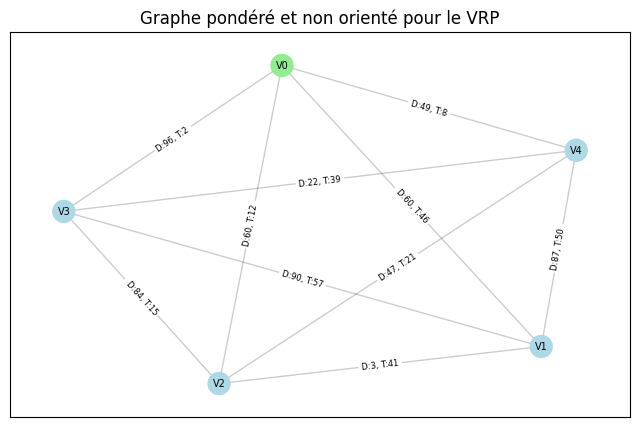

In [18]:
# Définition du nombre de sommets du graphe
N = 5

# Génère un graphe complet avec pondérations aléatoires sur les distances et temps
G = generate_graph(N)

# Renomme les sommets pour qu'ils aient des noms plus lisibles (V0, V1, ..., Vn)
G = nx.relabel_nodes(G, lambda x: f"V{x}")

# Dessine le graphe avec les poids affichés sur chaque arête
# Le sommet 'V0' est défini comme dépôt
draw_graph(G, depots="V0", title="Graphe pondéré et non orienté pour le VRP")

# Affiche le graphe
plt.show()

### Transformation du VRP en TSP

Pour transformer le VRP en TSP, **on crée 𝑘 copies du dépôt dans le graphe**. Ces copies représentent **les 𝑘 tournées distinctes du VRP**. En attribuant des coûts très élevés entre ces copies, on empêche le TSP de relier plusieurs dépôts dans une même boucle. Chaque copie devient ainsi le départ et l’arrivée d’une tournée spécifique, simulant l’utilisation de 𝑘 véhicules dans le TSP.
Plusieurs contraintes sont respectés pour les poids des aretes
- Les distances entre les clients sont conservées
- Les distances entre les copies du dépôt sont fixées à **une grande valeur 𝑀** pour décourager le passage direct entre ces copies
-Les distances entre chaque copie du dépôt $v_0^{(i)}$ et les clients sont égales à celles du dépôt original $v_0$ dans l’instance VRP.


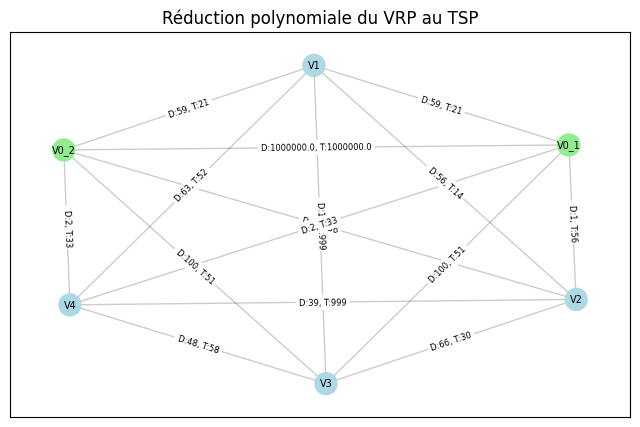

In [19]:
# Nombre de sommets (clients + dépôt)
N = 5
# Nombre de camions
K = 2

# 1. Génère un graphe complet pondéré (distances et temps aléatoires)
G = generate_graph(N)

# Renomme les sommets : V0, V1, ..., VN
G = nx.relabel_nodes(G, lambda x: f"V{x}")

# 2. Duplique le dépôt (V0) en K copies : V0_1, V0_2, ..., V0_K
clients = [n for n in G if n != "V0"]  # On récupère tous les clients (nœuds sauf le dépôt)
for k in range(1, K + 1):
    d = f"V0_{k}"  # Nouveau nom du dépôt pour le k-ième camion
    # On ajoute des arêtes entre le dépôt dupliqué et les clients,
    # en copiant les poids des arêtes initiales entre V0 et chaque client
    G.add_edges_from((d, c, G["V0"][c]) for c in clients)

# 3. Ajoute des arêtes entre dépôts dupliqués avec un coût très élevé
# Cela interdit au TSP de passer directement d’un dépôt à un autre
depots = [f"V0_{k}" for k in range(1, K + 1)]
for i in range(1, K + 1):
    for j in range(i + 1, K + 1):
        G.add_edge(f"V0_{i}", f"V0_{j}", distance=1e6, time=1e6)

# 4. Supprime l’ancien dépôt original ("V0") du graphe
G.remove_node("V0")

# 5. Dessine le graphe modifié avec les dépôts dupliqués mis en évidence
draw_graph(G, depots=depots, title="Réduction polynomiale du VRP au TSP")

###  Conclusion sur la complexité du VRP

Le **Vehicle Routing Problem (VRP)** est une **généralisation** du **problème du voyageur de commerce (TSP)**.

Nous avons montré qu’une instance de VRP peut être transformée en une instance **équivalente de TSP en temps polynomial**, notamment en **dupliquant le dépôt** et en **modifiant les coûts** du graphe.

Or, le **TSP est un problème NP-complet**, ce qui signifie qu’il **n’existe pas d’algorithme polynomial connu** permettant de le résoudre efficacement dans tous les cas.

Cette réduction polynomiale montre donc que le VRP est lui aussi **NP-Difficile**, car **il est au moins aussi complexe que le TSP**.


### Génération des instances aléatoires

In [20]:
# Génère une graine aléatoire entre 0 et 100000
seed = random.randint(0, 100000)

# Initialise le générateur de nombres aléatoires avec cette graine
# Cela permet de reproduire exactement les mêmes résultats si on relance le programme avec la même seed
random.seed(seed)

# Affiche la seed utilisée pour pouvoir la réutiliser si besoin
print(f"Seed : {seed}")

Seed : 74095


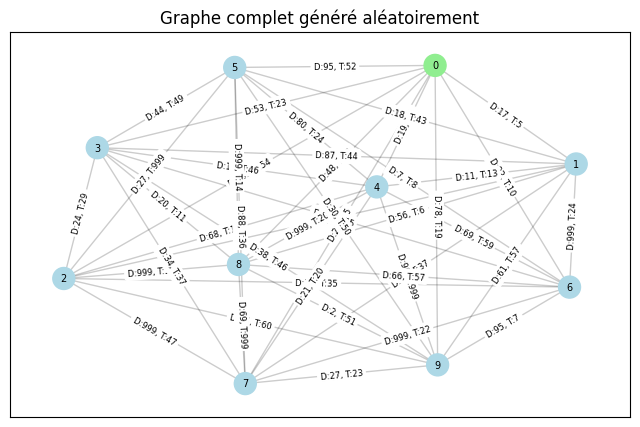

In [21]:
N = 10  # Nombre de sommets (villes ou points à visiter)
K = 2   # Nombre de camions

# Génération d'un graphe complet avec 15 sommets
# Chaque arête reçoit une distance et un temps aléatoires
G = generate_graph(N)

# Affichage du graphe généré avec les distances et temps sur les arêtes
draw_graph(G)

# Modélisation linéaire du problème de tournées de véhicules pour minimiser la distance (VRP)

Ce modèle linéaire permet de résoudre un problème de tournées de véhicules, où plusieurs camions partent d’un dépôt, visitent des clients, puis reviennent au dépôt.  
L’objectif est de **minimiser la distance totale parcourue** tout en respectant certaines contraintes.


##  Données du problème

Le système est modélisé par un **graphe orienté pondéré** $G = (V, E)$ :

- $V = \{v_0, v_1, ..., v_n\}$ : ensemble des sommets, représentant les clients à visiter.  
- $v_0$ désigne le **dépôt** (point de départ et d’arrivée).
- $E \subseteq V \times V$ : ensemble des arêtes (routes).
- Chaque arête $(i, j) \in E$ est associée à une **distance** $d_{ij} \in \mathbb{R}^+$.
### Variable binaire $x_{ij}^k$ :

- **Définition** : $x_{ij}^k = 1$ si le véhicule $k$ emprunte l'arc (route) entre les sommets $i$ et $j$, et $0$ sinon.
- **Formulation** : $x_{ij}^k \in \{0, 1\}, \quad \forall i, j \in V, \, \forall k \in \{1, \dots, K\}$
- **Interprétation** : Cette variable indique si une route est utilisée par un véhicule donné.

### Variable entière $u_i^k$ :

- **Définition** : $u_i^k$ représente l'ordre de visite du sommet $i$ par le véhicule $k$.
- **Formulation** : $u_i^k \in \mathbb{Z}, \quad 1 \leq u_i^k \leq n, \quad \forall i \in V, \, \forall k \in \{1, \dots, K\}$
- **Interprétation** : Cette variable est utilisée pour éviter les sous-tours (cycles qui ne passent pas par le dépôt).



##  Fonction objectif

Minimiser la **distance totale parcourue** :

$$
\min \sum_{(i,j) \in E} d_{ij} \cdot x_{ij}
$$


##  Contraintes


#### 1. Chaque client est visité exactement une fois

**Formulation :**

$$
\sum_{i \in V, \, i \neq j} \sum_{k=1}^K x_{ij}^k = 1, \quad \forall j \in V
$$

$$
\sum_{j \in V, \, j \neq i} \sum_{k=1}^K x_{ij}^k = 1, \quad \forall i \in V
$$

**Explication :**  
Chaque client doit être visité une seule fois par un véhicule, et chaque véhicule doit quitter un client après l'avoir visité.

#### 2. Les véhicules partent et reviennent au dépôt

**Formulation :**

$$
\sum_{j \in V} x_{0j}^k = 1, \quad \forall k \in \{1, \dots, K\}
$$

$$
\sum_{i \in V} x_{i0}^k = 1, \quad \forall k \in \{1, \dots, K\}
$$

**Explication :**  
Chaque véhicule doit partir du dépôt et y revenir à la fin de sa tournée.

#### 3. Conservation du flux

**Formulation :**

$$
\sum_{i \in V, \, i \neq v} x_{iv}^k = \sum_{j \in V, \, j \neq v} x_{vj}^k, \quad \forall v \in V, \, \forall k \in \{1, \dots, K\}
$$

**Explication :**  
Si un véhicule arrive à un sommet, il doit repartir de ce sommet.


#### 4. Élimination des sous-tours (MTZ)

**Formulation :**

$$
u_i^k - u_j^k + n \cdot x_{ij}^k \leq n - 1, \quad \forall i, j \in V, \, i \neq j, \, \forall k \in \{1, \dots, K\}
$$

**Explication :**  
Cette contrainte empêche la formation de cycles qui ne passent pas par le dépôt.



#### 5. Équilibrage des clients entre les véhicules

**Formulation :**

$$
L \leq \sum_{i \in V} \sum_{j \in V, \, j \neq i} x_{ij}^k \leq U, \quad \forall k \in \{1, \dots, K\}
$$

**Explication :**  
Chaque véhicule doit visiter un nombre de clients compris entre une limite inférieure \( L \) et une limite supérieure \( U \).


##  Interprétation

Ce modèle permet de :

- Planifier les tournées de $k$ véhicules partant et revenant au dépôt $v_0$
- Assurer la visite unique de chaque client
- Éviter les cycles internes sans passer par le dépôt
- **Minimiser la distance totale** pour un impact économique et écologique réduit

In [22]:
def PL_VRP(G, K, depot=0):
    customers = [v for v in G.nodes if v != depot]      # Sommets à visiter
    m = len(customers)                                  # Nombre de clients
    L = m // K                                          # Nombre minimum de clients par camion
    U = L if m % K == 0 else L + 1                      # Nombre maximum de clients par camion

    arcs = [(i, j) for i in G.nodes for j in G.nodes if i != j]

    # --- Définir le problème --- #
    prob = pulp.LpProblem("Distance_VRP", pulp.LpMinimize)

    # --- Variables de décision --- #
    # x[i,j,k] = 1 si le camion k prend l'arc (i,j), 0 sinon
    # u[i,k] = Nombre de clients visités par le camion k avant le client i
    x = pulp.LpVariable.dicts("x", ((i, j, k) for (i, j) in arcs for k in range(K)), lowBound=0, upBound=1, cat="Binary")
    u = pulp.LpVariable.dicts("u", ((i, k) for i in customers for k in range(K)), lowBound=1, upBound=m, cat="Integer")

    # --- Fonction objectif : minimiser la distance totale parcourue --- #
    prob += pulp.lpSum(G.edges[i, j]["distance"] * x[(i, j, k)] for (i, j) in arcs for k in range(K))

    # --- Contraintes --- #
    # Chaque client exactement une fois
    for i in customers:
        prob += pulp.lpSum(x[(i, j, k)] for j in G.nodes if j != i for k in range(K)) == 1

    # Un départ & un retour dépôt par camion
    for k in range(K):
        prob += pulp.lpSum(x[(0, j, k)] for j in customers) == 1
        prob += pulp.lpSum(x[(i, 0, k)] for i in customers) == 1

    # Conservation du flux
    for k in range(K):
        for v in customers:
            prob += (pulp.lpSum(x[(i, v, k)] for i in G.nodes if i != v) - pulp.lpSum(x[(v, j, k)] for j in G.nodes if j != v)) == 0

    # MTZ : élimination des sous-tours
    for k in range(K):
        for i, j in itertools.permutations(customers, 2):
            prob += u[(i, k)] - u[(j, k)] + m * x[(i, j, k)] <= m - 1

    # Équilibrage (même nombre de clients ±1 par camion)
    # L = m // K, U = L + 1 si m % K != 0
    # L <= nombre de clients par camion <= U
    for k in range(K):
        prob += pulp.lpSum(x[(i, j, k)] for i in customers for j in G.nodes if j != i) >= L
        prob += pulp.lpSum(x[(i, j, k)] for i in customers for j in G.nodes if j != i) <= U

    # Résolution
    prob.solve(pulp.PULP_CBC_CMD(msg=False))

    # Récupération des arêtes sélectionnées pour chaque camion
    routes = [[] for _ in range(K)]
    for k in range(K):
        for i, j in arcs:
            if pulp.value(x[(i, j, k)]) > 0.5:
                routes[k].append((i, j))

    return routes


RÉSUMÉ GLOBAL
Distance totale : 246
Temps max       : 157

Camion      Distance     Temps   Tournée
-------------------------------------------------
0                102       141   0 → 4 → 3 → 8 → 9 → 7 → 0
1                144       157   0 → 5 → 6 → 2 → 1 → 0


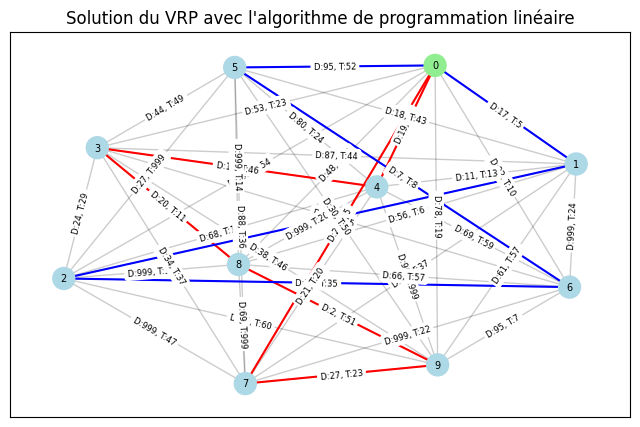

In [23]:
# Cette fonction retourne les routes optimisées et la distance totale minimale.
solution = PL_VRP(G, K)

# Pour chaque tournée, elle affiche les nœuds visités et la distance parcourue.
print_solution(G, solution)

# Affiche le graphe avec les tournées optimales visualisées
draw_graph(G, solution, title="Solution du VRP avec l'algorithme de programmation linéaire")

## Méta heuristique
Nous avons fait le choix d'utiliser deux méta heuristiques pour résoudre notre problème de tournées de véhicules. Ces deux algorithmes sont les suivants :
- **la colonie de fourmis** : qui s'inspire du comportement des fourmis pour trouver le chemin le plus court entre le dépôt et les clients.
- **la recherche tabou** : qui utilise une mémoire pour éviter de revisiter les solutions déjà explorées, permettant ainsi d'explorer efficacement l'espace de recherche.

### Colonie de fourmis :

Pourquoi avoir choisi la méthaheuristique colonie de fourmi ?

- Elles ne cherchent pas toutes les solutions possibles.  
- Elles explorent intelligemment l’espace des solutions pour trouver de bonnes solutions, parfois très proches de l’optimal.
- Même si elles ne garantissent pas d'avoir la meilleure solution, elles donnent des résultats très corrects en peu de temps.

Cette méthode s'inspire du comportement des fourmis. Elles sont guidées par des phéromones tout en gardant une part d'exploration. De plus, la méthode est facile à adapter à nos contraintes et limite le risque de rester bloqué dans le problème. Elle fonctionne naturellement sur le système de graphes comme le problème de VRP.

In [24]:
def ants_VRP(G, K, depot=0, num_ants=10, iterations=300, alpha=1, beta=2, evaporation_rate=0.5, pheromone_init=1.0):
    # Initialisation des phéromones sur chaque arête
    pheromones = {edge: pheromone_init for edge in G.edges}
    
    best_routes = None
    best_cost = float('inf')
    
    # Liste des nœuds sans le dépôt
    nodes = list(G.nodes)
    nodes.remove(depot)
    
    # Répartition approximative des clients par véhicule
    nodes_per_vehicle = len(nodes) // K
    extra_nodes = len(nodes) % K
    
    courantes = []              # Coût minimal trouvé à chaque itération
    meilleures_courantes = []   # Meilleur coût global trouvé jusqu'à chaque itération

    for iteration in range(iterations):
        iteration_best_cost = float('inf')  # Meilleur coût de cette itération

        for ant in range(num_ants):  # Pour chaque fourmi
            unvisited = set(G.nodes)
            unvisited.remove(depot)
            routes = []
            total_cost = 0

            for vehicle in range(K):
                current_route = [depot]
                current_node = depot
                visited_this_trip = set()
                
                # Nombre de clients à visiter pour ce véhicule
                nodes_to_visit = nodes_per_vehicle + (1 if vehicle < extra_nodes else 0)

                while unvisited and len(visited_this_trip) < nodes_to_visit:
                    neighbors = [n for n in G.neighbors(current_node) if n in unvisited]
                    if not neighbors:
                        break

                    probabilities = []
                    for neighbor in neighbors:
                        # Calcul de la probabilité en fonction des phéromones et de la distance
                        edge = (current_node, neighbor) if (current_node, neighbor) in pheromones else (neighbor, current_node)
                        pheromone = pheromones[edge]
                        distance = G[current_node][neighbor]['distance']
                        probabilities.append((neighbor, (pheromone ** alpha) * ((1 / distance) ** beta)))

                    if not probabilities:
                        break

                    total_prob = sum(prob[1] for prob in probabilities)
                    # Choix du prochain nœud en fonction des probabilités
                    next_node = random.choices(
                        [node for node, _ in probabilities],
                        [prob / total_prob for _, prob in probabilities]
                    )[0]

                    current_route.append(next_node)
                    total_cost += G[current_node][next_node]['distance']
                    unvisited.remove(next_node)
                    visited_this_trip.add(next_node)
                    current_node = next_node

                # Retour au dépôt à la fin de la tournée
                if current_node != depot:
                    current_route.append(depot)
                    total_cost += G[current_node][depot]['distance']

                routes.append(current_route)

            # Mise à jour du meilleur coût global et local
            if total_cost < best_cost:
                best_cost = total_cost
                best_routes = routes

            if total_cost < iteration_best_cost:
                iteration_best_cost = total_cost

        courantes.append(iteration_best_cost)
        meilleures_courantes.append(best_cost)

        # Évaporation des phéromones
        for edge in pheromones:
            pheromones[edge] *= (1 - evaporation_rate)

        # Renforcement des arêtes empruntées dans la meilleure solution trouvée
        for route in best_routes:
            for i in range(len(route) - 1):
                edge = (route[i], route[i + 1]) if (route[i], route[i + 1]) in pheromones else (route[i + 1], route[i])
                pheromones[edge] += 1 / best_cost

    # Conversion des routes en listes d'arêtes pour affichage
    formatted_routes = []
    for route in best_routes:
        edges = [(route[i], route[i + 1]) for i in range(len(route) - 1)]
        formatted_routes.append(edges)

    return formatted_routes


RÉSUMÉ GLOBAL
Distance totale : 246
Temps max       : 157

Camion      Distance     Temps   Tournée
-------------------------------------------------
0                102       141   0 → 7 → 9 → 8 → 3 → 4 → 0
1                144       157   0 → 1 → 2 → 6 → 5 → 0


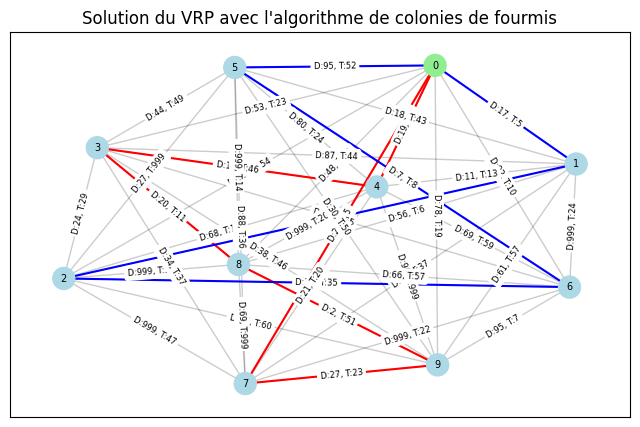

In [25]:
# Cette fonction retourne les routes et la distance totale minimale trouvées par l'algorithme de colonies de fourmis.
solution = ants_VRP(G, K)

# Pour chaque tournée, elle affiche les nœuds visités et la distance parcourue.
print_solution(G, solution)

# Affiche le graphe avec les tournées optimales visualisées
draw_graph(G, solution, title="Solution du VRP avec l'algorithme de colonies de fourmis")

### Recherche tabou

Pourquoi avoir choisi la méthaheuristique recherche tabou ?

- Elle se souvient des mauvaises solutions récemment visitées grâce à une liste tabou.
- Capacité à améliorer une solution initiale, elle prend souvent une solution de base (intelligente ou aléatoire) et l’améliore progressivement.
- Elle est facile à adapter à nos contraintes et bon compromis qualité / temps.

La recherche tabou est choisie pour le VRP car elle est simple à implémenter, robuste, améliore progressivement les solutions, et surtout, elle évite les blocages dans des solutions locales sous-optimales.

In [26]:
def smart_initial_solution(G, K, depot=0):
    nodes = list(G.nodes())
    nodes.remove(depot)
    
    # Trier les clients selon leur distance au dépôt
    nodes.sort(key=lambda node: G[depot][node]['distance'] if G.has_edge(depot, node) else G[node][depot]['distance'])

    # Répartition équilibrée des clients entre les camions
    split = [len(nodes) // K] * K
    for i in range(len(nodes) % K):
        split[i] += 1

    # Construction des routes pour chaque camion
    solution = []
    idx = 0
    for s in split:
        route = [depot] + nodes[idx:idx+s] + [depot]
        idx += s
        solution.append(route)
    return solution


def calculate_cost(G, solution):
    total_cost = 0
    for route in solution:
        for i in range(len(route) - 1):
            u, v = route[i], route[i+1]
            if G.has_edge(u, v): total_cost += G[u][v]['distance']
            elif G.has_edge(v, u): total_cost += G[v][u]['distance']
            else: total_cost += 9999  # pénalité si arc manquant
    return total_cost


def tabu_VRP(G, K, depot=0, iterations=500, tabu_tenure=15):
    solution = smart_initial_solution(G, K, depot)      # Solution initiale
    best_solution = [route[:] for route in solution]    # Copie superficielle
    best_cost = calculate_cost(G, best_solution)

    tabu_list = []              # Liste tabou pour éviter les solutions déjà visitées
    courantes = []              # Coûts courants à chaque itération
    meilleures_courantes = []   # Meilleurs coûts globaux

    for _ in range(iterations):
        neighborhood = []

        # Génération du voisinage : échange de clients entre camions
        for i in range(K):
            for j in range(1, len(solution[i]) - 1):  # Ne pas échanger le dépôt
                for k in range(K):
                    if i != k:
                        for l in range(1, len(solution[k]) - 1):
                            neighbor = [route[:] for route in solution]
                            neighbor[i][j], neighbor[k][l] = neighbor[k][l], neighbor[i][j]

                            # Vérification tabou
                            if neighbor not in tabu_list:
                                neighborhood.append((neighbor, calculate_cost(G, neighbor)))

        if not neighborhood:
            break

        # Sélection du meilleur voisin
        neighborhood.sort(key=lambda x: x[1])
        solution, current_cost = neighborhood[0]

        if current_cost < best_cost:
            best_solution = [route[:] for route in solution]
            best_cost = current_cost

        # Mise à jour de la liste tabou
        tabu_list.append(solution)
        if len(tabu_list) > tabu_tenure:
            tabu_list.pop(0)

        # Suivi des évolutions
        courantes.append(current_cost)
        meilleures_courantes.append(best_cost)

    # Conversion des routes en listes d’arêtes pour affichage
    routes = []
    for route in best_solution:
        edges = [(route[i], route[i + 1]) for i in range(len(route) - 1)]
        routes.append(edges)
    return routes


RÉSUMÉ GLOBAL
Distance totale : 263
Temps max       : 177

Camion      Distance     Temps   Tournée
-------------------------------------------------
0                146       177   0 → 1 → 2 → 6 → 5 → 3 → 0
1                117       132   0 → 4 → 7 → 9 → 8 → 0


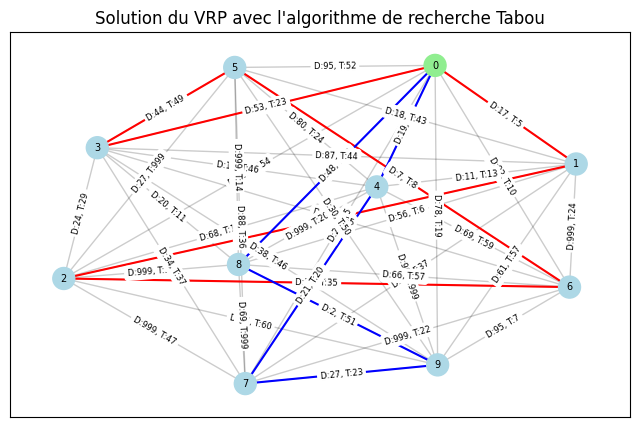

In [27]:
# Cette fonction retourne les routes et la distance totale minimale trouvées par la recherche tabou.
solution = tabu_VRP(G, K)

# Pour chaque tournée, elle affiche les nœuds visités et la distance parcourue.
print_solution(G, solution)

# Affiche le graphe avec les tournées optimales visualisées
draw_graph(G, solution, title="Solution du VRP avec l'algorithme de recherche Tabou")

### Ecart entre les métaheuristiques et Le PL

In [28]:
def run_algorithms_fixed_instance_size(N=10, K=2, instances=10, with_pl=True):
    results = {
        'instance': [],
        'method': [],
        'distance': [],
        'time': []
    }

    for rep in range(instances):  # Répéter plusieurs fois pour chaque instance
        
        # Générer une graine unique pour chaque répétition
        seed = random.randint(0, 100000)
        random.seed(seed)
        G_test = generate_graph(N)

        print(f"Instance {rep + 1}/{instances}, Seed: {seed}")
        
        distance_pl = None
        time_pl = None

        # === Programmation Linéaire (PL) ===
        if with_pl:
            try:
                start_time = time.time()
                solution_pl = PL_VRP(G_test, K)
                distance_pl = sum(G_test.edges[u, v]['distance'] for edges in solution_pl for u, v in edges)
                time_pl = time.time() - start_time

                results['instance'].append(rep + 1)
                results['method'].append('PL')
                results['distance'].append(distance_pl)
                results['time'].append(time_pl)
            except:
                distance_pl = None
                time_pl = None

        # === Recherche Tabou ===
        try:
            start_time = time.time()
            solution_tabu = tabu_VRP(G_test, K)
            distance_tabu = sum(G_test.edges[u, v]['distance'] for edges in solution_tabu for u, v in edges)
            elapsed_time_tabu = time.time() - start_time

            results['instance'].append(rep + 1)
            results['method'].append('Tabou')
            results['distance'].append(distance_tabu)
            results['time'].append(elapsed_time_tabu)
        except:
            pass

        # === Colonie de Fourmis ===
        try:
            start_time = time.time()
            solution_ants = ants_VRP(G_test, K)
            distance_ants = sum(G_test.edges[u, v]['distance'] for edges in solution_ants for u, v in edges)
            elapsed_time_ants = time.time() - start_time

            results['instance'].append(rep + 1)
            results['method'].append('Fourmis')
            results['distance'].append(distance_ants)
            results['time'].append(elapsed_time_ants)
        except:
            pass

    # Organisation des résultats dans un DataFrame
    df_results = pd.DataFrame(results)

    # Calcul des écarts uniquement si PL est présent
    differences = []
    if with_pl:
        for instance in df_results['instance'].unique():
            pl_row = df_results[(df_results['instance'] == instance) & (df_results['method'] == 'PL')]
            for method in ['Tabou', 'Fourmis']:
                method_row = df_results[(df_results['instance'] == instance) & (df_results['method'] == method)]
                if not pl_row.empty and not method_row.empty:
                    diff_distance = method_row['distance'].values[0] - pl_row['distance'].values[0]
                    diff_time = method_row['time'].values[0] - pl_row['time'].values[0]
                    differences.append({
                        'instance': instance,
                        'method': method,
                        'diff_distance': diff_distance,
                        'diff_time': diff_time
                    })

    df_differences = pd.DataFrame(differences)

    return df_results, df_differences


Instance 1/10, Seed: 5902
Instance 2/10, Seed: 94952
Instance 3/10, Seed: 41961
Instance 4/10, Seed: 9139
Instance 5/10, Seed: 57966
Instance 6/10, Seed: 51585
Instance 7/10, Seed: 99232
Instance 8/10, Seed: 41246
Instance 9/10, Seed: 66745
Instance 10/10, Seed: 50898


Moyenne et écart type des distances et des temps pour chaque méthode :

         mean_distance  std_distance  mean_time  std_time
method                                                   
Fourmis          282.7     56.350195   0.261301  0.036563
PL               274.6     60.371443   1.722328  0.902764
Tabou            309.1     65.788297   0.129926  0.005772


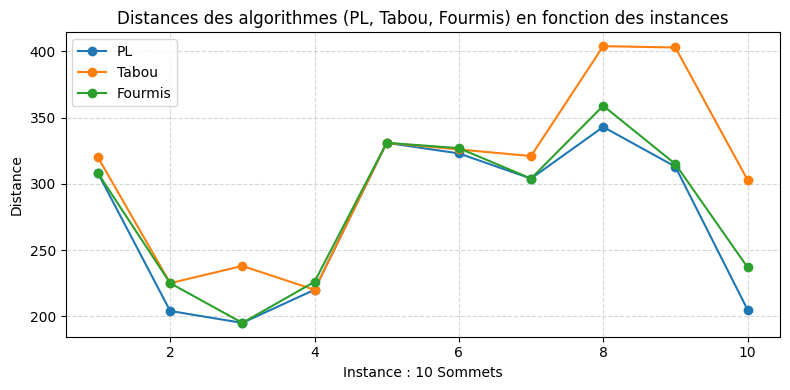


Moyenne et écart type des écarts (différences) entre PL et les méta-heuristiques :

         mean_diff_distance  std_diff_distance  mean_diff_time  std_diff_time
method                                                                       
Fourmis                 8.1          11.159948       -1.461027       0.877733
Tabou                  34.5          36.900015       -1.592402       0.898276


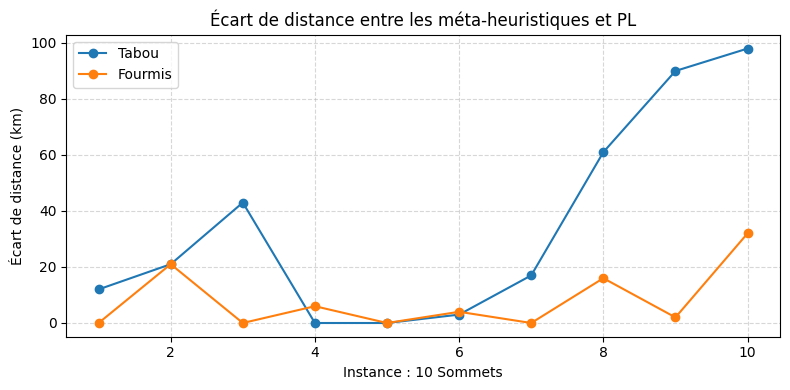

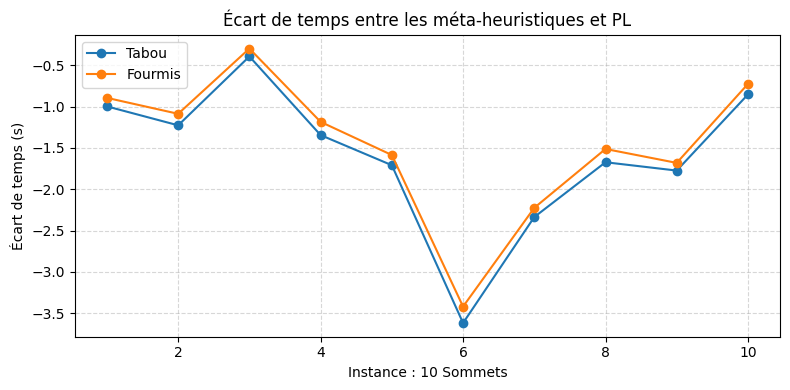

In [29]:
df_results, df_differences = run_algorithms_fixed_instance_size(N=10, K=2, instances=10)

# Affichage des résultats
# --- Calcul des moyennes et écarts types --- #
print("\n\nMoyenne et écart type des distances et des temps pour chaque méthode :\n")
stats = df_results.groupby('method').agg(
    mean_distance=('distance', 'mean'),
    std_distance=('distance', 'std'),
    mean_time=('time', 'mean'),
    std_time=('time', 'std')
)
print(stats)

# --- Distances des algorithmes en fonction des instances --- #
plot_graph(df=df_results, methods=['PL', 'Tabou', 'Fourmis'], x_col='instance', y_col='distance', xlabel=f'Instance : {N} Sommets', ylabel='Distance', title='Distances des algorithmes (PL, Tabou, Fourmis) en fonction des instances')

# --- Moyenne et écart type des écarts (différences) --- #
print("\nMoyenne et écart type des écarts (différences) entre PL et les méta-heuristiques :\n")
diff_stats = df_differences.groupby('method').agg(
    mean_diff_distance=('diff_distance', 'mean'),
    std_diff_distance=('diff_distance', 'std'),
    mean_diff_time=('diff_time', 'mean'),
    std_diff_time=('diff_time', 'std')
)
print(diff_stats)

# --- Graphique : écart de distance --- #
plot_graph(df=df_differences, methods=['Tabou', 'Fourmis'], x_col='instance', y_col='diff_distance', xlabel=f'Instance : {N} Sommets', ylabel='Écart de distance (km)', title='Écart de distance entre les méta-heuristiques et PL')

# --- Graphique : écart de temps --- #
plot_graph(df=df_differences, methods=['Tabou', 'Fourmis'], x_col='instance', y_col='diff_time', xlabel=f'Instance : {N} Sommets', ylabel='Écart de temps (s)', title='Écart de temps entre les méta-heuristiques et PL')

### Analyse globale des performances des méthodes (Tabou, Fourmis, PL)
- **Description générale** :  
    Cette analyse compare trois approches de résolution d’un problème d’optimisation combinatoire (par exemple, le VRP ou le TSP) selon deux critères principaux :
    - Qualité de la solution (distance moyenne parcourue)
    - Temps d’exécution moyen

- **Qualité des solutions (distance moyenne)** :  
    PL est généralement la méthode qui fournit les solutions les plus optimales (distances les plus courtes), car elle explore systématiquement l’espace des solutions. Les méta-heuristiques (Tabou, Fourmis) offrent des résultats légèrement moins bons, mais très proches dans certains cas. **Tabou** a tendance à produire des résultats plus stables et légèrement meilleurs que **Fourmis** sur certaines instances.

- **Temps d’exécution** :  
    PL est la plus lente, avec un temps croissant exponentiellement selon la taille du problème. Elle peut devenir inutilisable sur de grandes instances. **Tabou** et **Fourmis** sont très rapides et permettent un traitement en temps réel ou quasi temps réel. **Tabou** est souvent plus stable temporellement. **Fourmis** peut nécessiter plusieurs itérations pour converger, ce qui peut allonger le temps sur certaines instances.

- **Stabilité** :  
    Les distances obtenues par PL sont constantes, car l’algorithme est déterministe. Les méta-heuristiques montrent une variabilité, dépendante des paramètres de configuration (nombre d’itérations, intensité de la recherche, stratégies d’exploration/exploitation). **Tabou** tend à être plus régulier dans ses résultats, moins sensible aux variations aléatoires que **Fourmis**.

- **Interprétation générale** :  
    PL doit être utilisée si le temps de calcul n’est pas un facteur limitant et que l’on recherche la meilleure solution possible. **Tabou** est un bon compromis entre vitesse et qualité. Elle est adaptée aux instances de taille moyenne à grande.

**Colonie de Fourmis** est une alternative efficace dans des contextes où le parallélisme ou l’exploration massive est souhaitée, malgré une légère baisse de performance par rapport à **Tabou**.

### 

In [37]:
def run_algorithms_variable_instance_size(N_min=5, N_max=15, K=2, repetitions=10, with_pl=True):
    all_results = []        # Stocke tous les résultats détaillés
    all_differences = []    # Stocke tous les écarts
    
    for N in range(N_min, N_max + 1):
        print(f"\n=== Graphes de taille {N} ===")
        df_results, df_differences = run_algorithms_fixed_instance_size(N=N, K=K, instances=repetitions, with_pl=with_pl)

        # Ajouter la taille du graphe dans les DataFrames
        df_results['graph_size'] = N
        df_differences['graph_size'] = N

        # Afficher les résultats détaillés pour cette taille
        print("\nRésultats complets :")
        print(df_results)

        # Stocker tous les résultats pour résumé final
        all_results.append(df_results)
        all_differences.append(df_differences)

    # Fusion de toutes les données
    df_all_results = pd.concat(all_results, ignore_index=True)
    df_all_differences = pd.concat(all_differences, ignore_index=True)

    # Calcul des moyennes ET écarts-types pour distance et temps
    df_summary_results = df_all_results.groupby(['graph_size', 'method']).agg(
        mean_distance=('distance', 'mean'),
        std_distance=('distance', 'std'),
        mean_time=('time', 'mean'),
        std_time=('time', 'std')
    ).reset_index()

    # Calcul des moyennes ET écarts-types pour les différences
    if with_pl:
        df_summary_differences = df_all_differences.groupby(['graph_size', 'method']).agg(
            mean_diff_distance=('diff_distance', 'mean'),
            std_diff_distance=('diff_distance', 'std'),
            mean_diff_time=('diff_time', 'mean'),
            std_diff_time=('diff_time', 'std')
        ).reset_index()
    else:
        df_summary_differences = []
        
    return df_summary_results, df_summary_differences

In [ ]:
df_results, df_differences = run_algorithms_variable_instance_size(N_min=5, N_max=15, K=2, repetitions=10)

print("\n\nMoyenne et écart type des distances et des temps pour chaque méthode :\n")
print(df_results)

print("\n\nMoyenne et écart type des écarts (différences) entre PL et les méta-heuristiques :\n")
print(df_differences)

# # Affichage des résultats
# --- Moyennes de distances des algorithmes en fonction de la taille des instances --- #
plot_graph(df=df_results, methods=['PL', 'Tabou', 'Fourmis'], x_col='graph_size', y_col='mean_distance', xlabel=f'Taille des instances', ylabel='Distance moyenne (km)', title='Distances des algorithmes (PL, Tabou, Fourmis) en fonction de la taille des instances', with_errorbar=True, error_col='std_distance')

# --- Ecarts moyens de distance entre PL et les méta-heuristiques en fonction de la taille des instances --- #
plot_graph(df=df_differences, methods=['Tabou', 'Fourmis'], x_col='graph_size', y_col='mean_diff_distance', xlabel=f'Taille des instances', ylabel='Écart moyen de distance avec PL', title='Écart moyen de distance avec PL en fonction du nombre de sommets')


=== Graphes de taille 5 ===
Instance 1/10, Seed: 52890
Instance 2/10, Seed: 50680
Instance 3/10, Seed: 11030
Instance 4/10, Seed: 98197
Instance 5/10, Seed: 83162
Instance 6/10, Seed: 16359
Instance 7/10, Seed: 40091
Instance 8/10, Seed: 62212
Instance 9/10, Seed: 12491
Instance 10/10, Seed: 23391

Résultats complets :
    instance   method  distance      time  graph_size
0          1       PL       222  0.122195           5
1          1    Tabou       222  0.014061           5
2          1  Fourmis       222  0.083604           5
3          2       PL      2113  0.094270           5
4          2    Tabou      2113  0.010866           5
5          2  Fourmis      2120  0.069851           5
6          3       PL      1241  0.093701           5
7          3    Tabou      1241  0.012928           5
8          3  Fourmis      1241  0.082582           5
9          4       PL      1156  0.089518           5
10         4    Tabou      1156  0.012227           5
11         4  Fourmis      115

### Analyse du graphique : Temps moyen d'exécution en fonction du nombre de sommets (Tabou et Fourmis)
- **Description générale** :  
    Ce graphique met en évidence l’évolution du temps moyen d’exécution des algorithmes **Tabou** et **Colonie de Fourmis** en fonction de la taille du graphe (nombre de sommets).

- **Observations** :  
    Croissance du temps avec la taille du graphe :
    Le temps moyen augmente progressivement avec le nombre de sommets pour les deux méthodes. Cela est cohérent avec la complexité croissante de résolution à mesure que les graphes deviennent plus denses.

- **Comparaison des performances** :  

    Tabou est systématiquement plus rapide que Colonie de Fourmis, parfois de manière significative (par exemple, à 10 sommets : 0.13s pour **Tabou** contre 0.19s pour **Fourmis**).

    La différence est plus marquée pour les graphes de grande taille, où le coût computationnel augmente.

- **Stabilité** :  
    L'écart-type du temps d'exécution pour **Tabou** reste globalement plus faible que celui de **Fourmis**, ce qui indique une meilleure stabilité temporelle.

- **Interprétation** :  
    L’algorithme **Tabou** est plus efficace en termes de temps d’exécution, surtout sur les graphes de taille moyenne à grande. En revanche, l’algorithme **Colonie de Fourmis**, bien que plus lent, peut compenser par une meilleure qualité de solution (comme vu dans l’analyse précédente sur les distances).

Cela suggère que **Tabou** est à privilégier dans des contextes à fortes contraintes de temps, tandis que **Fourmis** peut être envisagé lorsque l’optimalité du résultat est prioritaire, au détriment du temps.

### Distance moyenne en fonction du nombre de clients

Taille du graphe : 5, Instance 1/5, Seed: 56540
Taille du graphe : 5, Instance 2/5, Seed: 55981
Taille du graphe : 5, Instance 3/5, Seed: 78167
Taille du graphe : 5, Instance 4/5, Seed: 13114
Taille du graphe : 5, Instance 5/5, Seed: 14685
Taille du graphe : 6, Instance 1/5, Seed: 57207
Taille du graphe : 6, Instance 2/5, Seed: 78307
Taille du graphe : 6, Instance 3/5, Seed: 42274
Taille du graphe : 6, Instance 4/5, Seed: 87319
Taille du graphe : 6, Instance 5/5, Seed: 55562
Taille du graphe : 7, Instance 1/5, Seed: 52540
Taille du graphe : 7, Instance 2/5, Seed: 38743
Taille du graphe : 7, Instance 3/5, Seed: 39072
Taille du graphe : 7, Instance 4/5, Seed: 54398
Taille du graphe : 7, Instance 5/5, Seed: 27658
Taille du graphe : 8, Instance 1/5, Seed: 80767
Taille du graphe : 8, Instance 2/5, Seed: 21560
Taille du graphe : 8, Instance 3/5, Seed: 74456
Taille du graphe : 8, Instance 4/5, Seed: 60515
Taille du graphe : 8, Instance 5/5, Seed: 73602
Taille du graphe : 9, Instance 1/5, Seed

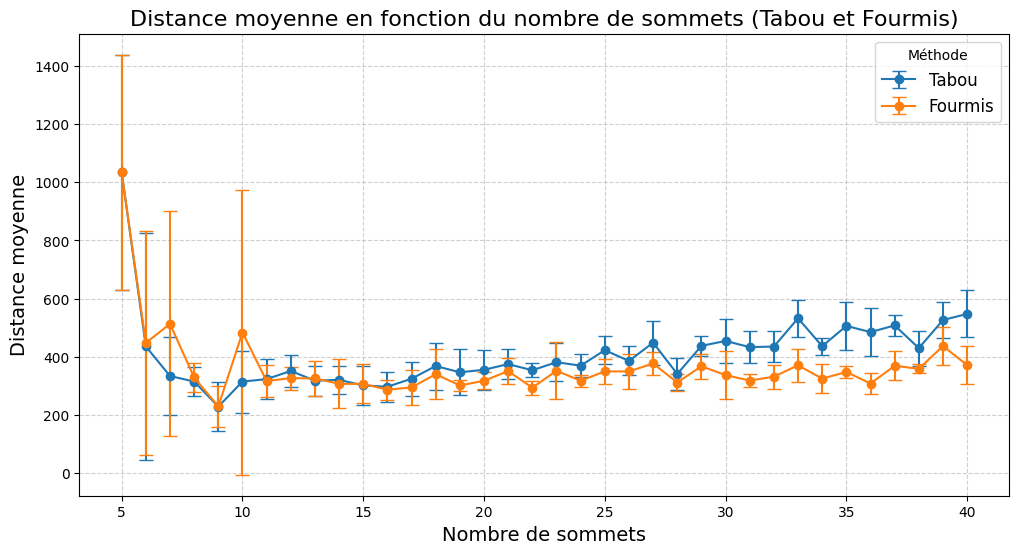

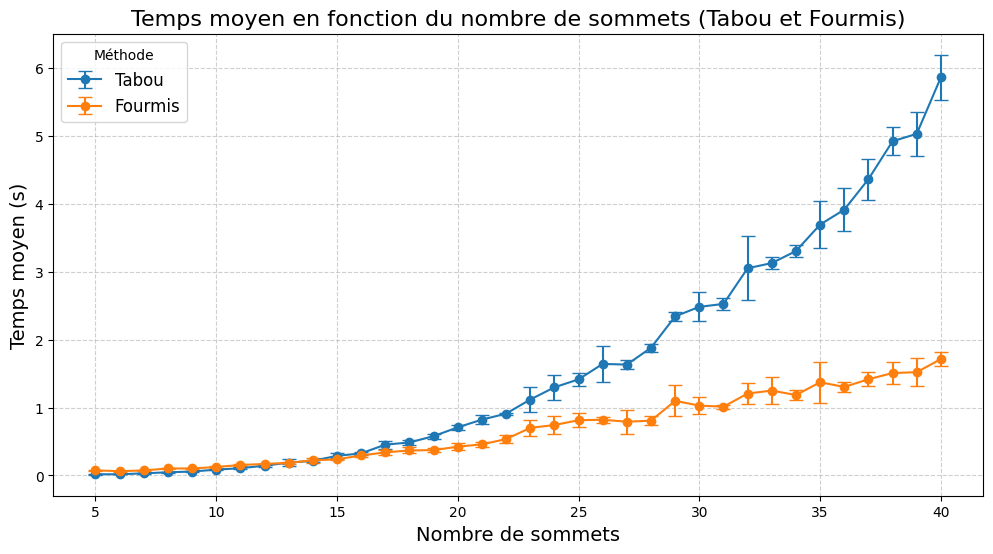

In [ ]:
df_results, df_differences = run_algorithms_variable_instance_size(N_min=5, N_max=30, K=2, repetitions=10, with_pl=False)

print("\n\nMoyenne et écart type des distances et des temps pour chaque méthode :\n")
print(df_results)

# # Affichage des résultats
# --- Moyennes de distances des algorithmes en fonction de la taille des instances --- #
plot_graph(df=df_results, methods=['Tabou', 'Fourmis'], x_col='graph_size', y_col='mean_distance', xlabel=f'Taille des instances', ylabel='Distance moyenne (km)', title='Distances des algorithmes (Tabou, Fourmis) en fonction de la taille des instances', with_errorbar=True, error_col='std_distance')

# --- Moyenne des temps des algorithmes en fonction de la taille des instances --- #
plot_graph(df=df_results, methods=['Tabou', 'Fourmis'], x_col='graph_size', y_col='mean_time', xlabel=f'Taille des instances', ylabel='Temps moyen (s)', title='Temps des algorithmes (Tabou, Fourmis) en fonction de la taille des instances', with_errorbar=True, error_col='std_time')

### Analyse du graphique : Distance moyenne en fonction du nombre de sommets (Tabou et Fourmis)

- **Description générale** :  
  Ce graphique montre l'évolution de la distance moyenne parcourue par les algorithmes **Tabou** et **Colonie de Fourmis** en fonction du nombre de sommets dans le graphe.

- **Observations** :  
  Pour les graphes de petite taille (5 à 10 sommets), les distances moyennes varient fortement, ce qui peut être dû à la nature aléatoire des graphes générés.
  À mesure que le nombre de sommets augmente, les distances moyennes augmentent également, ce qui est attendu car un graphe plus grand implique des trajets plus longs.
  L'algorithme **Colonie de Fourmis** semble produire des distances légèrement inférieures à celles de **Tabou** pour la plupart des tailles de graphes, ce qui pourrait indiquer une meilleure optimisation dans ce cas.

- **Interprétation** :  
  La **Colonie de Fourmis** semble être plus stable et performante en termes de distance moyenne, bien que cela dépende des paramètres spécifiques des algorithmes.

### Optimisation de l'algorithme de la colonie de fourmis

L'optimisation réalisée ici est plus une **préoptimisation** qu'une véritable optimisation exhaustive. Elle consiste à ajuster certains paramètres clés de l'algorithme de colonie de fourmis, tels que le nombre de fourmis, le nombre d'itérations, les paramètres alpha et beta, ainsi que les taux d'évaporation et de phéromones initiales. L'objectif est de trouver des valeurs qui minimisent la distance totale parcourue pour un graph. Cependant, cette approche ne garantit pas une solution optimale globale, car elle repose sur des tests limités à des plages de valeurs prédéfinies et un nombre restreint de répétitions. Elle permet néanmoins d'identifier des configurations raisonnables pour ces paramètres.

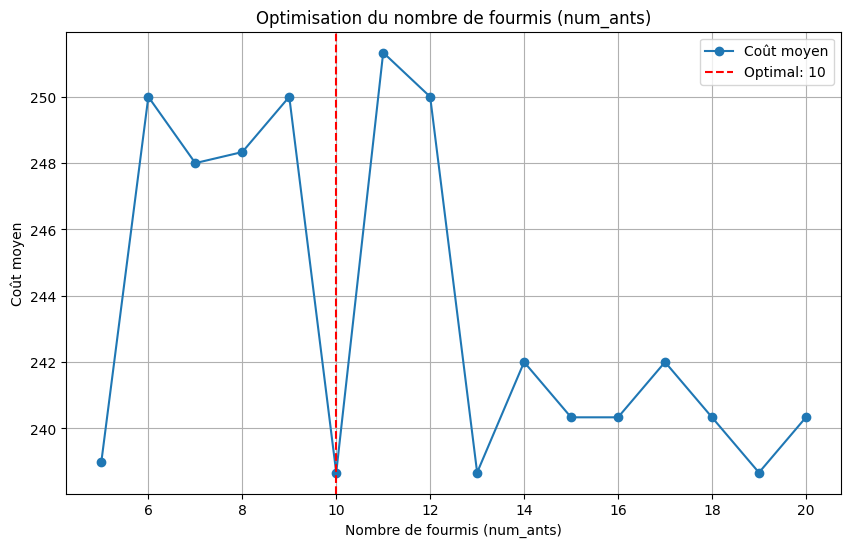

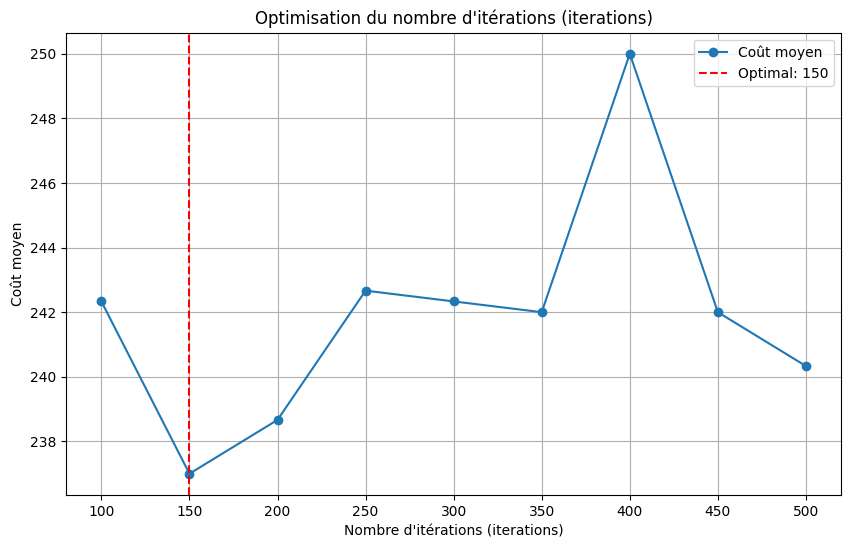

In [ ]:
def optimize_num_ants(graph, depot, nombre_camion=2, num_ants_range=(5, 20), fixed_params=None, repetitions=3):
    """
    Optimise le nombre de fourmis (num_ants) en fixant les autres paramètres et affiche un graphique.
    """
    if fixed_params is None:
        fixed_params = {'iterations': 300, 'alpha': 2, 'beta': 4, 'evaporation_rate': 0.5, 'pheromone_init': 1.5}

    costs = []  # Liste pour stocker les coûts moyens
    num_ants_values = range(num_ants_range[0], num_ants_range[1] + 1)

    for num_ants in num_ants_values:
        total_cost = 0
        for _ in range(repetitions):
            solution_ants = ants_VRP(
                graph, nombre_camion, depot, num_ants=num_ants,
                iterations=fixed_params['iterations'], alpha=fixed_params['alpha'],
                beta=fixed_params['beta'], evaporation_rate=fixed_params['evaporation_rate'],
                pheromone_init=fixed_params['pheromone_init']
            )
            distance_ants = sum(graph.edges[u, v]['distance'] for edges in solution_ants for u, v in edges)
            total_cost += distance_ants
        avg_cost = total_cost / repetitions
        costs.append(avg_cost)

    best_num_ants = num_ants_values[costs.index(min(costs))]
    best_cost = min(costs)

    plt.figure(figsize=(10, 6))
    plt.plot(num_ants_values, costs, marker='o', label='Coût moyen')
    plt.axvline(best_num_ants, color='red', linestyle='--', label=f'Optimal: {best_num_ants}')
    plt.xlabel('Nombre de fourmis (num_ants)')
    plt.ylabel('Coût moyen')
    plt.title('Optimisation du nombre de fourmis (num_ants)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_num_ants, best_cost


def optimize_iterations(graph, depot, nombre_camion=2, iterations_range=(100, 500), fixed_params=None, repetitions=3):
    """
    Optimise le nombre d'itérations (iterations) en fixant les autres paramètres et affiche un graphique.
    """
    if fixed_params is None:
        fixed_params = {'num_ants': 10, 'alpha': 2, 'beta': 4, 'evaporation_rate': 0.5, 'pheromone_init': 1.5}

    costs = []  # Liste pour stocker les coûts moyens
    iterations_values = range(iterations_range[0], iterations_range[1] + 1, 50)

    for iterations in iterations_values:
        total_cost = 0
        for _ in range(repetitions):
            solution_ants = ants_VRP(
                graph, nombre_camion, depot, num_ants=fixed_params['num_ants'],
                iterations=iterations, alpha=fixed_params['alpha'], beta=fixed_params['beta'],
                evaporation_rate=fixed_params['evaporation_rate'], pheromone_init=fixed_params['pheromone_init']
            )
            distance_ants = sum(graph.edges[u, v]['distance'] for edges in solution_ants for u, v in edges)
            total_cost += distance_ants
        avg_cost = total_cost / repetitions
        costs.append(avg_cost)

    best_iterations = iterations_values[costs.index(min(costs))]
    best_cost = min(costs)

    plt.figure(figsize=(10, 6))
    plt.plot(iterations_values, costs, marker='o', label='Coût moyen')
    plt.axvline(best_iterations, color='red', linestyle='--', label=f'Optimal: {best_iterations}')
    plt.xlabel('Nombre d\'itérations (iterations)')
    plt.ylabel('Coût moyen')
    plt.title('Optimisation du nombre d\'itérations (iterations)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_iterations, best_cost


def optimize_alpha(graph, depot, nombre_camion=2, alpha_range=(1, 3), fixed_params=None, repetitions=3):
    """
    Optimise le paramètre alpha en fixant les autres paramètres et affiche un graphique.
    """
    if fixed_params is None:
        fixed_params = {'num_ants': 10, 'iterations': 300, 'beta': 4, 'evaporation_rate': 0.5, 'pheromone_init': 1.5}

    costs = []  # Liste pour stocker les coûts moyens
    alpha_values = [round(x, 1) for x in list(frange(alpha_range[0], alpha_range[1], 0.1))]

    for alpha in alpha_values:
        total_cost = 0
        for _ in range(repetitions):
            solution_ants = ants_VRP(
                graph, nombre_camion, depot, num_ants=fixed_params['num_ants'],
                iterations=fixed_params['iterations'], alpha=alpha, beta=fixed_params['beta'],
                evaporation_rate=fixed_params['evaporation_rate'], pheromone_init=fixed_params['pheromone_init']
            )
            distance_ants = sum(graph.edges[u, v]['distance'] for edges in solution_ants for u, v in edges)
            total_cost += distance_ants
        avg_cost = total_cost / repetitions
        costs.append(avg_cost)

    best_alpha = alpha_values[costs.index(min(costs))]
    best_cost = min(costs)

    plt.figure(figsize=(10, 6))
    plt.plot(alpha_values, costs, marker='o', label='Coût moyen')
    plt.axvline(best_alpha, color='red', linestyle='--', label=f'Optimal: {best_alpha}')
    plt.xlabel('Paramètre alpha')
    plt.ylabel('Coût moyen')
    plt.title('Optimisation du paramètre alpha')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_alpha, best_cost


def optimize_beta(graph, depot, nombre_camion=2, beta_range=(2, 6), fixed_params=None, repetitions=3):
    """
    Optimise le paramètre beta en fixant les autres paramètres et affiche un graphique.
    """
    if fixed_params is None:
        fixed_params = {'num_ants': 10, 'iterations': 300, 'alpha': 2, 'evaporation_rate': 0.5, 'pheromone_init': 1.5}

    costs = []  # Liste pour stocker les coûts moyens
    beta_values = [round(x, 1) for x in list(frange(beta_range[0], beta_range[1], 0.1))]

    for beta in beta_values:
        total_cost = 0
        for _ in range(repetitions):
            solution_ants = ants_VRP(
                graph, nombre_camion, depot, num_ants=fixed_params['num_ants'],
                iterations=fixed_params['iterations'], alpha=fixed_params['alpha'], beta=beta,
                evaporation_rate=fixed_params['evaporation_rate'], pheromone_init=fixed_params['pheromone_init']
            )
            distance_ants = sum(graph.edges[u, v]['distance'] for edges in solution_ants for u, v in edges)
            total_cost += distance_ants
        avg_cost = total_cost / repetitions
        costs.append(avg_cost)

    best_beta = beta_values[costs.index(min(costs))]
    best_cost = min(costs)

    plt.figure(figsize=(10, 6))
    plt.plot(beta_values, costs, marker='o', label='Coût moyen')
    plt.axvline(best_beta, color='red', linestyle='--', label=f'Optimal: {best_beta}')
    plt.xlabel('Paramètre beta')
    plt.ylabel('Coût moyen')
    plt.title('Optimisation du paramètre beta')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_beta, best_cost
def optimize_pheromone_init(graph, depot, nombre_camion=2, pheromone_range=(1.0, 2.0), fixed_params=None, repetitions=3):
    """
    Optimise la valeur initiale des phéromones (pheromone_init) en fixant les autres paramètres,
    en testant plusieurs valeurs, et affiche un graphique des coûts moyens.
    """
    if fixed_params is None:
        fixed_params = {'num_ants': 10, 'iterations': 300, 'alpha': 2, 'beta': 4, 'evaporation_rate': 0.5}

    costs = []  # Liste pour stocker les coûts moyens
    pheromone_values = [round(x, 1) for x in list(frange(pheromone_range[0], pheromone_range[1], 0.1))]

    for pheromone_init in pheromone_values:
        total_cost = 0
        for _ in range(repetitions):
            solution_ants = ants_VRP(
                graph, nombre_camion, depot, num_ants=fixed_params['num_ants'],
                iterations=fixed_params['iterations'], alpha=fixed_params['alpha'], beta=fixed_params['beta'],
                evaporation_rate=fixed_params['evaporation_rate'], pheromone_init=pheromone_init
            )
            distance_ants = sum(graph.edges[u, v]['distance'] for edges in solution_ants for u, v in edges)
            total_cost += distance_ants
        avg_cost = total_cost / repetitions
        costs.append(avg_cost)

    best_pheromone_init = pheromone_values[costs.index(min(costs))]
    best_cost = min(costs)

    plt.figure(figsize=(10, 6))
    plt.plot(pheromone_values, costs, marker='o', label='Coût moyen')
    plt.axvline(best_pheromone_init, color='red', linestyle='--', label=f'Optimal: {best_pheromone_init}')
    plt.xlabel('Phéromones initiales (pheromone_init)')
    plt.ylabel('Coût moyen')
    plt.title('Optimisation des phéromones initiales (pheromone_init)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_pheromone_init, best_cost


def optimize_evaporation_rate(graph, depot, nombre_camion=2, evaporation_range=(0.3, 0.7), fixed_params=None, repetitions=3):
    """
    Optimise le taux d'évaporation (evaporation_rate) en testant plusieurs valeurs possibles,
    en gardant les autres paramètres constants, et affiche un graphique des coûts moyens.
    """
    if fixed_params is None:
        fixed_params = {'num_ants': 10, 'iterations': 300, 'alpha': 2, 'beta': 4, 'pheromone_init': 1.5}

    costs = []  # Liste pour stocker les coûts moyens
    evaporation_values = [round(x, 1) for x in list(frange(evaporation_range[0], evaporation_range[1], 0.1))]

    for evaporation_rate in evaporation_values:
        total_cost = 0
        for _ in range(repetitions):
            solution_ants = ants_VRP(
                graph, nombre_camion, depot, num_ants=fixed_params['num_ants'],
                iterations=fixed_params['iterations'], alpha=fixed_params['alpha'], beta=fixed_params['beta'],
                evaporation_rate=evaporation_rate, pheromone_init=fixed_params['pheromone_init']
            )
            distance_ants = sum(graph.edges[u, v]['distance'] for edges in solution_ants for u, v in edges)
            total_cost += distance_ants
        avg_cost = total_cost / repetitions
        costs.append(avg_cost)

    best_evaporation_rate = evaporation_values[costs.index(min(costs))]
    best_cost = min(costs)

    plt.figure(figsize=(10, 6))
    plt.plot(evaporation_values, costs, marker='o', label='Coût moyen')
    plt.axvline(best_evaporation_rate, color='red', linestyle='--', label=f'Optimal: {best_evaporation_rate}')
    plt.xlabel('Taux d\'évaporation (evaporation_rate)')
    plt.ylabel('Coût moyen')
    plt.title('Optimisation du taux d\'évaporation (evaporation_rate)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_evaporation_rate, best_cost

def frange(start, stop, step):
    """
    Génère une plage de nombres flottants.
    """
    while start < stop:
        yield start
        start += step


# Exemple d'utilisation
graph = generate_graph(15)  # Générer un graphe avec 15 sommets
depot = 0  # Dépôt

# Optimiser chaque paramètre individuellement
best_num_ants, cost_num_ants = optimize_num_ants(graph, depot)
best_iterations, cost_iterations = optimize_iterations(graph, depot)
best_alpha, cost_alpha = optimize_alpha(graph, depot)
best_beta, cost_beta = optimize_beta(graph, depot)
best_pheromone_init, cost_pheromone_init = optimize_pheromone_init(graph, depot)
best_evaporation_rate, cost_evaporation_rate = optimize_evaporation_rate(graph, depot)

## Conclusion du projet
Dans le cadre de ce projet, nous avons étudié la résolution du problème de tournées de véhicules (VRP). L’objectif principal consistait à optimiser les trajets de plusieurs véhicules partant d’un dépôt pour desservir un ensemble de clients, tout en minimisant la distance totale des tournées. Pour ce faire, deux métaheuristiques ont été mises en œuvre : l’algorithme de colonie de fourmis (Ant Colony Optimization, ACO) et la recherche tabou (Tabu Search).

L’algorithme ACO s’appuie sur le comportement collectif des fourmis pour construire progressivement des solutions, en tenant compte d’une fonction heuristique (basée sur les distances) et de l’intensité des phéromones. Un travail d’ajustement des paramètres alpha et beta a été réalisé afin d’améliorer les performances de l’algorithme. Des simulations ont permis d’identifier les plages de valeurs optimales, en mesurant le coût moyen obtenu selon différentes configurations. Ce processus a mis en évidence l’importance d’un équilibre entre exploration (beta) et exploitation (alpha) dans la recherche de solutions efficaces.

Parallèlement, nous avons implémenté un algorithme de recherche tabou, visant à améliorer localement une solution initiale en explorant des solutions voisines, tout en évitant les cycles grâce à une mémoire des mouvements interdits (liste tabou). Cette méthode s’est révélée particulièrement performante pour affiner des solutions préexistantes, avec un temps de calcul réduit et une convergence rapide vers des optima locaux de qualité.

En conclusion, ce projet a permis de démontrer la pertinence de ces techniques pour résoudre des problèmes logistiques complexes. Une perspective intéressante serait de combiner les deux approches au sein d’une métaheuristique hybride, en utilisant l’ACO pour produire des solutions de départ, puis la recherche tabou pour les raffiner. De plus, ces travaux pourraient être étendus à des variantes plus réalistes du VRP, telles que les contraintes de capacité, les fenêtres de temps ou les multi-dépôts.

### Références utiles

- https://fr.wikipedia.org/wiki/Probl%C3%A8me_du_voyageur_de_commerce
- https://fr.wikipedia.org/wiki/Probl%C3%A8me_de_tourn%C3%A9es_de_v%C3%A9hicules
- Workshop
- https://networkx.org/documentation/stable/reference/introduction.html
- https://www.guru99.com/fr/travelling-salesman-problem.html#:~:text=Le%20probl%C3%A8me%20du%20voyageur%20de%20commerce%20%28TSP%29%20est,fa%C3%A7on%20exponentielle%20avec%20l%E2%80%99augmentation%20du%20nombre%20de%20villes.
- https://github.com/jwang0306/vehicle-routing-problem?tab=readme-ov-file
- https://www.youtube.com/watch?v=GiDsjIBOVoA&list=TLPQMjcwNDIwMjWGmE-QXy8F6w&index=1&pp=gAQBiAQB